# terceiro? modelo: modelo 03

efficien net com todas as features + data augmentation e é só

In [ ]:
import pandas as pd

In [ ]:
df_train = pd.read_pickle('Model_Train.pkl')
df_val = pd.read_pickle('Model_Val.pkl')

In [ ]:
set(df_train["img_placement"]) | set(df_val["img_placement"])

In [ ]:
set(df_train["img_origin"]) | set(df_val["img_origin"])

In [ ]:
def hot_encod_img_placement(df):
    extra_features_all = []
    for i, row in df.iterrows():
        extra_features = []
        if row["img_placement"] == "roof":
            extra_features += [1, 0, 0, 0]
        elif row["img_placement"] == "r_openspace":
            extra_features += [0, 1, 0, 0]
        elif row["img_placement"] == "openspace":
            extra_features += [0, 0, 1, 0]
        elif row["img_placement"] == "S-unknown":
            extra_features += [0, 0, 0, 1]
        else:
            extra_features += [0, 0, 0, 0]
        if row["img_origin"] == "D":
            extra_features += [1, 0]
        elif row["img_origin"] == "S":
            extra_features += [0, 1]
        else:
            extra_features += [0, 0] 
        extra_features_all.append(extra_features)
    
    df["more_features"] = extra_features_all

    df.drop(columns=["img_origin"], inplace=True)
    df.drop(columns=["img_placement"], inplace=True)

hot_encod_img_placement(df_train)
hot_encod_img_placement(df_val)

In [ ]:
df_train.sample(3)

---

## efficient net v2

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetV2B1
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import AdamW
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.utils import Sequence

In [ ]:
class ImageDataGeneratorCustom(tf.keras.utils.Sequence):
    def __init__(self, df, image_size=(512, 512), batch_size=32, shuffle=True, augment=False):
        self.df = df
        self.image_size = image_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.indexes = self.df.index.values
        self.on_epoch_end()

        if self.augment:
            self.transform = A.Compose([
                A.RandomResizedCrop((self.image_size[0], self.image_size[1]), scale=(0.7, 1.0), ratio=(0.75, 1.33)),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.RandomRotate90(p=0.5),
                A.GaussianBlur(blur_limit=(3, 7), p=0.3),
                A.CLAHE(clip_limit=4.0, p=0.5),
                A.HueSaturationValue(p=0.3),
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ToTensorV2()
            ])
        else:
            # If no augmentation, only resize and normalize
            self.transform = A.Compose([
                A.Resize(self.image_size[0], self.image_size[1]),
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ToTensorV2()
            ])

    def __len__(self):
        # Calculate the number of batches per epoch
        return int(np.floor(len(self.df) / self.batch_size))

    def on_epoch_end(self):
        # Shuffle the data at the end of each epoch if shuffle is True
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)
            #np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        # Get batch of data
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_df = self.df.iloc[batch_indexes]

        images = []
        labels = []
        extra_features = []

        for i, row in batch_df.iterrows():
            # Load image
            image_path = "images/" + row['img_id'] + '.jpg'
            img = load_img(image_path, target_size=self.image_size)
            img = img_to_array(img)  # Convert to numpy array
            img = img / 255.0 # Normalize pixel values
            
            img = self.transform(image=img)["image"]

            if img.shape[0] == 3:  # If it's in channels-first format (3, 512, 512)
                img = np.transpose(img, (1, 2, 0))

            
            images.append(img)
            labels.append((sum(row["nr_boil"]), sum(row["nr_pan"])))
            extra_features.append(row["more_features"])

        return (np.array(images), np.array(extra_features)), np.array(labels)


In [ ]:
train_generator = ImageDataGeneratorCustom(df_train, image_size=(512, 512), batch_size=32, shuffle=True, augment=True)
val_generator = ImageDataGeneratorCustom(df_val, image_size=(512, 512), batch_size=32, shuffle=False, augment=False)

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.applications import EfficientNetV2B1
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.losses import Huber

# Define image input
image_input = Input(shape=(512, 512, 3), name="image_input")

# Define extra features input (6 additional features)
extra_input = Input(shape=(6,), name="extra_features")

# Base model (EfficientNetV2-B1 without the top layers)
base_model = EfficientNetV2B1(weights="imagenet", include_top=False, input_tensor=image_input)
base_model.trainable = False  # Freeze EfficientNet for feature extraction

# Feature extraction from CNN
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Reduce spatial dimensions

# Merge image features with extra input
x = Concatenate()([x, extra_input])  # Combine CNN features with extra features

# Dense layers
x = Dense(512, activation="relu")(x)
x = Dropout(0.35)(x)
output = Dense(2)(x)  # Regression output (2 values)

# Define and compile the model
model = Model(inputs=[image_input, extra_input], outputs=output)

model.compile(
    optimizer=AdamW(learning_rate=0.00014),
    loss=Huber(delta=1.0),
    metrics=["mae"]
)

In [ ]:
#model.summary()

In [ ]:
from tensorflow.keras import callbacks
from time import time

# Define ModelCheckpoint to save model after each epoch
checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=f"ModelBuild/Model03_{int(time())}.keras",
    save_weights_only=False,
    save_best_only=False,
    monitor="val_mae", 
    verbose=1
)

# Early stopping to prevent overfitting
early_stopping_callback = callbacks.EarlyStopping(
    monitor="val_mae",
    patience=10,
    restore_best_weights=True
)

#history = model.fit(train_generator,
#          validation_data=val_generator,
#          epochs=50,
#          callbacks=[checkpoint_callback, early_stopping_callback])

#model.save('ModelBuild/model03.keras')

In [95]:
import json

#a = history.history
#with open('ModelBuild/model03_history.json', 'w') as f:
#    json.dump(a, f)

with open('ModelBuild/model03_history.json') as f:
    data = json.load(f)

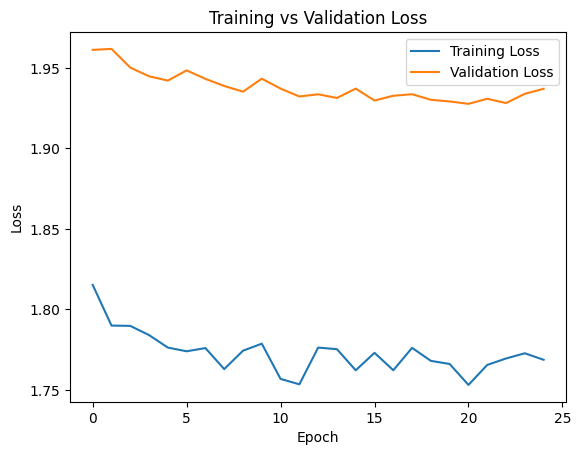

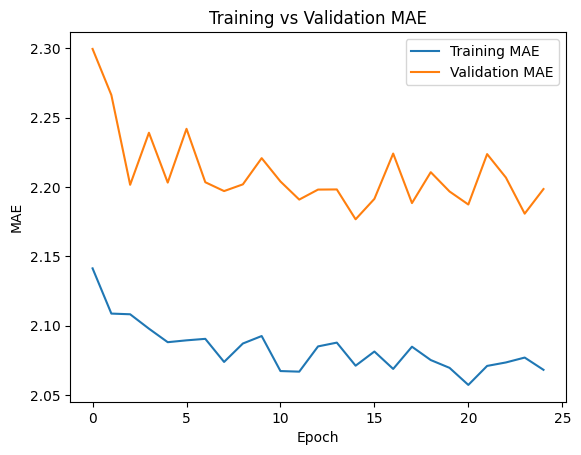

In [96]:
plt.plot(data['loss'], label='Training Loss')
plt.plot(data['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(data['mae'], label='Training MAE')
plt.plot(data['val_mae'], label='Validation MAE')
plt.title('Training vs Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

aplicar ao dataset de teste

In [122]:
teste = pd.read_csv("Test.csv")

teste.head(3)

,ID,img_origin,placement
0,ID00qprY,D,roof
1,ID01AciUc,D,roof
2,ID0328D,D,roof


In [123]:
def hot_encod_img_placement(df):
    extra_features_all = []
    for i, row in df.iterrows():
        extra_features = []
        if row["placement"] == "roof":
            extra_features += [1, 0, 0, 0]
        elif row["placement"] == "r_openspace":
            extra_features += [0, 1, 0, 0]
        elif row["placement"] == "openspace":
            extra_features += [0, 0, 1, 0]
        elif row["placement"] == "S-unknown":
            extra_features += [0, 0, 0, 1]
        else:
            extra_features += [0, 0, 0, 0]
        if row["img_origin"] == "D":
            extra_features += [1, 0]
        elif row["img_origin"] == "S":
            extra_features += [0, 1]
        else:
            extra_features += [0, 0] 
        extra_features_all.append(extra_features)
    
    df["more_features"] = extra_features_all

    df.drop(columns=["img_origin"], inplace=True)
    df.drop(columns=["placement"], inplace=True)

hot_encod_img_placement(teste)

In [124]:
teste.rename(columns={"ID": "img_id"}, inplace=True)

In [125]:
teste.head(3)

,img_id,more_features
0,ID00qprY,"[1, 0, 0, 0, 1, 0]"
1,ID01AciUc,"[1, 0, 0, 0, 1, 0]"
2,ID0328D,"[1, 0, 0, 0, 1, 0]"


In [126]:
submission = pd.read_csv("zindi_files/SampleSubmission.csv")

In [127]:
submission.head(3)

,ID,Target
0,ID00qprY_boil,0
1,ID00qprY_pan,0
2,ID01AciUc_boil,0


In [128]:
transform = A.Compose([
                A.Resize(512, 512),
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ToTensorV2()
            ])



for i, row in teste.iterrows():
    image_path = "images/" + row['img_id'] + '.jpg'
    img = load_img(image_path, target_size=(512, 512))
    img = img_to_array(img)  # Convert to numpy array
    img = img / 255.0 # Normalize pixel values

    img = transform(image=img)["image"]

    if img.shape[0] == 3:  # If it's in channels-first format (3, 512, 512)
        img = np.transpose(img, (1, 2, 0))

    img = np.expand_dims(img, axis=0)

    extra_features = np.array(row["more_features"]).reshape(1, 6)

    prediction = model.predict([img, extra_features], verbose=0)

    pred_nr_boil = prediction[0][0]
    
    pred_br_pan = prediction[0][1]


    submission.loc[submission['ID'] == f"{row['img_id']}_boil", "Target"] = pred_nr_boil
    submission.loc[submission['ID'] == f"{row['img_id']}_pan", "Target"] = pred_br_pan

    if i % 100 == 0:
        print(f"{i} images processed of {len(teste)}")

submission.head(2)

/var/folders/sz/96b_h5gn3y33k0c7jsvrstmm0000gn/T/ipykernel_1213/2923578107.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.0022027490194886923' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  submission.loc[submission['ID'] == f"{row['img_id']}_boil", "Target"] = pred_nr_boil


0 images processed of 1107
100 images processed of 1107
200 images processed of 1107
300 images processed of 1107
400 images processed of 1107
500 images processed of 1107
600 images processed of 1107
700 images processed of 1107
800 images processed of 1107
900 images processed of 1107
1000 images processed of 1107
1100 images processed of 1107


,ID,Target
0,ID00qprY_boil,-0.002203
1,ID00qprY_pan,2.013490


In [129]:
submission

,ID,Target
0,ID00qprY_boil,-0.002203
1,ID00qprY_pan,2.013490
2,ID01AciUc_boil,-0.002209
3,ID01AciUc_pan,2.013492
4,ID0328D_boil,-0.002206
...,...,...
2209,IDzwPcyO0e_pan,1.019069
2210,IDzzNegz_boil,-0.002212
2211,IDzzNegz_pan,2.013490
2212,IDzzZcEYNVZMCk_boil,-0.002209


In [130]:
submission.to_csv('zindi_files/model03_submission.csv', index=False)

**public score:** 2.97685302